In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ptls-dtf/ptls2.csv
/kaggle/input/ptls-dtf/ptls4.csv
/kaggle/input/data-fusion-contest-2024-2/report_dates.csv
/kaggle/input/data-fusion-contest-2024-2/clients.csv
/kaggle/input/data-fusion-contest-2024-2/train.csv
/kaggle/input/data-fusion-contest-2024-2/transactions.csv


In [91]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import roc_auc_score

# 1. Загрузка и описание данных

In [92]:
report_dates = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/report_dates.csv')
clients = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/clients.csv')
train = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/train.csv')
tran = pd.read_csv('/kaggle/input/data-fusion-contest-2024-2/transactions.csv')

### 1) train
В трейне есть данные о 64к клиентах. Для каждого клиента известна дата последней транзакции, перед отчётом ("time") и метка о том была ли эта транзакция последней ("target")

In [93]:
train.head()

,user_id,target,time
0,3,0,77
1,13,0,86
2,37,0,89
3,41,0,57
4,42,0,84


In [94]:
train.shape

(64000, 3)

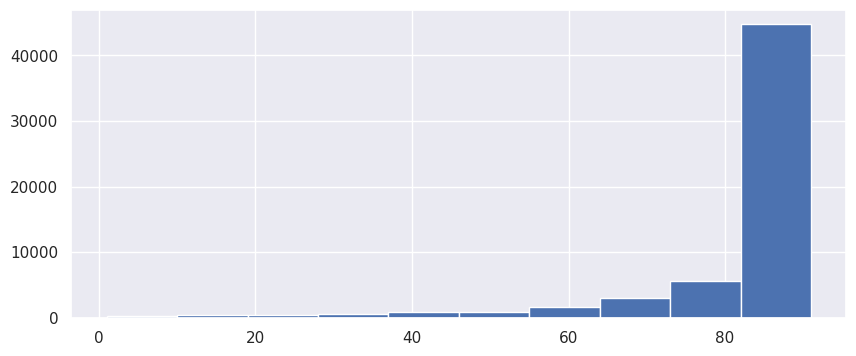

In [95]:
train.loc[train['target'] == 0, 'time'].hist(figsize=(10, 4));

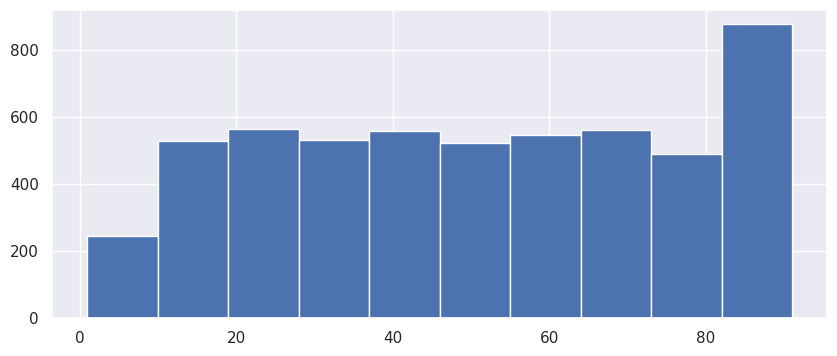

In [96]:
train.loc[train['target'] == 1, 'time'].hist(figsize=(10, 4));

### 2) clients

Данные о всех 96000 клиентах. В колонке "report" указывается номер отчёта, в котором была собрана информации по транзакциям о данном клиенте. В "employee_count_nm" информация о числе сотрудников в компании, в которой работает данный клиента. В "bankemplstatus" информация о том является ли клиент сотрудником банка. И в "customer_age" возраст клиента (4 группы: 0, 1, 2, 3)

In [97]:
clients.shape

(96000, 5)

In [98]:
clients.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age
0,3,2,ОТ 101 ДО 500,0,3
1,9,1,БОЛЕЕ 1001,0,3
2,13,6,ОТ 501 ДО 1000,0,2
3,37,5,БОЛЕЕ 1001,0,2
4,41,1,ОТ 101 ДО 500,0,2


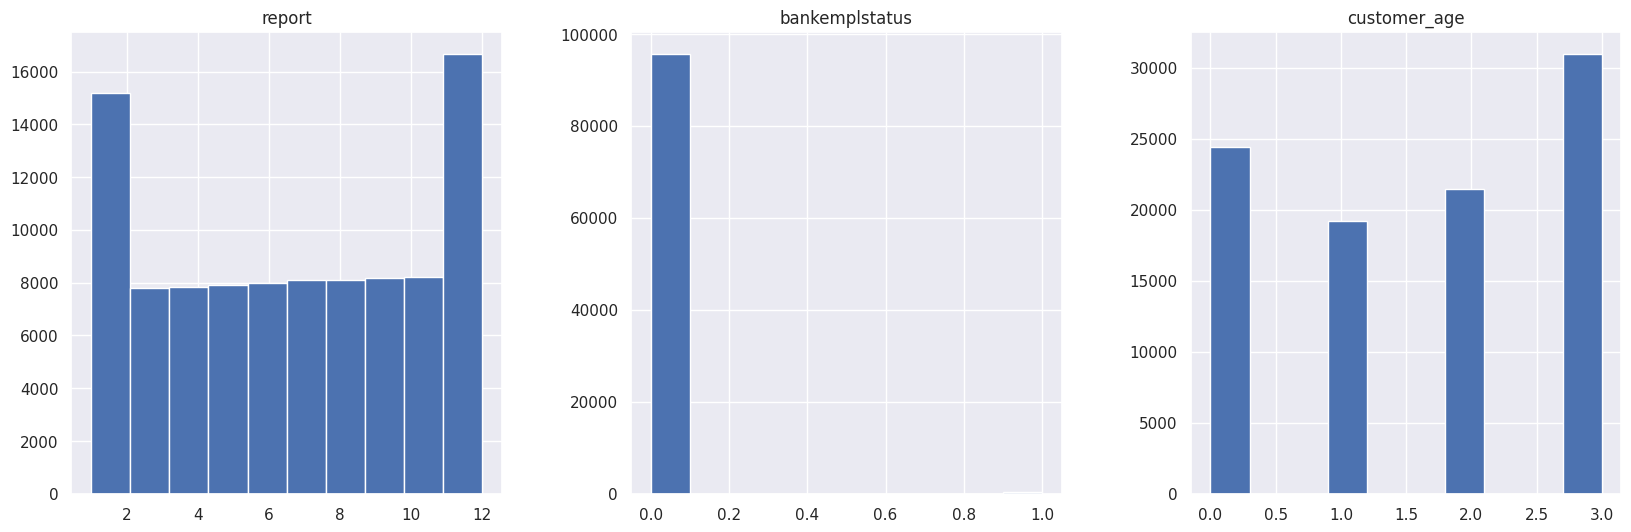

In [99]:
clients.drop(["user_id", "employee_count_nm"], axis=1).hist(figsize=(20, 6), layout=(-1, 3), );

In [100]:
clients['employee_count_nm'].value_counts()

employee_count_nm
БОЛЕЕ 1001        17833
ОТ 101 ДО 500     14362
ОТ 51 ДО 100       7314
ОТ 501 ДО 1000     6481
ОТ 11 ДО 50        4413
ДО 10              3797
БОЛЕЕ 500          1996
ОТ 11 ДО 30        1871
ОТ 31 ДО 50        1467
Name: count, dtype: int64

In [101]:
clients['bankemplstatus'].value_counts(normalize=True)

bankemplstatus
0    0.99674
1    0.00326
Name: proportion, dtype: float64

### 3) report dates и transactions

Всего 12 отчётов, отчёт проводится каждый месяц и в каждый отчёт попадают не все клиенты

In [102]:
report_dates

,report,report_dt
0,1,2022-07-31 03:00:00
1,2,2022-08-31 03:00:00
2,3,2022-09-30 03:00:00
3,4,2022-10-31 03:00:00
4,5,2022-11-30 03:00:00
5,6,2022-12-31 03:00:00
6,7,2023-01-31 03:00:00
7,8,2023-02-28 03:00:00
8,9,2023-03-31 03:00:00
9,10,2023-04-30 03:00:00


Список транзакций для каждого клиента. В "mcc_code" информация о коде транзакций(что за операция совершалась): 322 уникальных кода. В "currency_rk" информация о валюте транзакции: 4 разны валюты. В "transaction_amt" сумма в валюте транзакции и "transaction_dttm" дата и время совершение транзакции.

In [103]:
tran.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


In [104]:
tran.loc[tran['user_id'] == 3, :]

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31
5,3,0,1,534.363098,2022-04-11 20:48:26
6,3,0,1,4549.455078,2022-04-11 20:53:35
7,3,0,1,37991.929688,2022-04-29 18:42:58
8,3,0,1,28335.613281,2022-05-05 20:32:38
9,3,0,1,5386.999023,2022-05-14 20:14:31


In [105]:
tran['mcc_code'].value_counts().shape

(332,)

In [106]:
tran['currency_rk'].value_counts(normalize=True)

currency_rk
1    0.971396
0    0.028333
3    0.000137
2    0.000134
Name: proportion, dtype: float64

# 2. EDA

### Заменяем категориальный признак "employee_count_nm"

In [107]:
employee = {'ОТ 101 ДО 500':4,'БОЛЕЕ 1001':6,'ОТ 501 ДО 1000':5,'ДО 10':1,
            'ОТ 11 ДО 50':2,'ОТ 51 ДО 100':3,'БОЛЕЕ 500':5,'ОТ 11 ДО 30':2,
            'ОТ 31 ДО 50':2}
clients.loc[:, 'employee_count_nm'] = clients['employee_count_nm'].apply(lambda x: employee.get(x, 'NaN'))

In [108]:
clients['employee_count_nm'].value_counts()

employee_count_nm
NaN    36466
6      17833
4      14362
5       8477
2       7751
3       7314
1       3797
Name: count, dtype: int64

### Генерируем признаки из транзакций без учёт времени

In [109]:
tran.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm
0,3,3,1,-183.883957,2022-01-28 12:05:33
1,3,3,1,-3206.437012,2022-01-28 12:52:30
2,3,16,1,-153866.890625,2022-02-16 14:45:56
3,3,56,1,-15144.601562,2022-03-09 19:58:29
4,3,0,1,5297.908691,2022-03-12 18:11:31


**Разделение на отрицательный и положительные транзакции:**

In [110]:
tran['transaction_dttm'] = tran['transaction_dttm'].astype('datetime64[ns]')
tran['dayofweek'] = tran['transaction_dttm'].dt.dayofweek # день недели
tran['date'] = tran['transaction_dttm'].dt.date.astype('datetime64[ns]') # дата: год-месяц-число
tran['transaction_positive'] = np.where(tran['transaction_amt']>0,tran['transaction_amt'],0) # величина транзакции > 0
tran['transaction_negative'] = np.where( tran['transaction_amt']<0,tran['transaction_amt'],0) # величина транзакции < 0

In [111]:
def logsumabs(x):
    sumabs = x.abs().sum()
    if sumabs > 0:
        return np.log(sumabs)
    else:
        return 0

In [112]:
tran.head(10)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,dayofweek,date,transaction_positive,transaction_negative
0,3,3,1,-183.883957,2022-01-28 12:05:33,4,2022-01-28,0.000000,-183.883957
1,3,3,1,-3206.437012,2022-01-28 12:52:30,4,2022-01-28,0.000000,-3206.437012
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-02-16,0.000000,-153866.890625
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-03-09,0.000000,-15144.601562
4,3,0,1,5297.908691,2022-03-12 18:11:31,5,2022-03-12,5297.908691,0.000000
5,3,0,1,534.363098,2022-04-11 20:48:26,0,2022-04-11,534.363098,0.000000
6,3,0,1,4549.455078,2022-04-11 20:53:35,0,2022-04-11,4549.455078,0.000000
7,3,0,1,37991.929688,2022-04-29 18:42:58,4,2022-04-29,37991.929688,0.000000
8,3,0,1,28335.613281,2022-05-05 20:32:38,3,2022-05-05,28335.613281,0.000000
9,3,0,1,5386.999023,2022-05-14 20:14:31,5,2022-05-14,5386.999023,0.000000


In [113]:
monetary = tran.groupby(['user_id', 'currency_rk'])['transaction_amt'].agg(
    [lambda x: np.log(x.abs().sum())])
monetary = monetary.unstack().fillna(0)
monetary.columns = ['lgsum_0','lgsum_1','logsum_2','logsum_3']
monetary.head()

,lgsum_0,lgsum_1,logsum_2,logsum_3
user_id,,,,
3,0.00000,12.789712,0.0,0.0
9,0.00000,12.686752,0.0,0.0
13,9.28478,12.825245,0.0,0.0
37,0.00000,12.775178,0.0,0.0
41,0.00000,11.595303,0.0,0.0


*Добавим количество валют, в которых клиент проводил транзакции:*

In [114]:
monetary['currency_nunique'] = (monetary != 0).sum(axis=1)

In [115]:
monetary_positive = tran.groupby(['user_id', 'currency_rk'])['transaction_positive'].agg(
    [logsumabs, lambda x: (x != 0).sum()])
monetary_positive = monetary_positive.unstack().fillna(0)
monetary_positive.columns = ['logsum_pos_0','logsum_pos_1','logsum_pos_2','logsum_pos_3',
                     'count_pos_0', 'count_pos_1', 'count_pos_2', 'count_pos_3']
monetary_positive.head()

,logsum_pos_0,logsum_pos_1,logsum_pos_2,logsum_pos_3,count_pos_0,count_pos_1,count_pos_2,count_pos_3
user_id,,,,,,,,
3,0.00000,12.134084,0.0,0.0,0.0,7.0,0.0,0.0
9,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
13,9.28478,11.678388,0.0,0.0,1.0,7.0,0.0,0.0
37,0.00000,9.281618,0.0,0.0,0.0,2.0,0.0,0.0
41,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [116]:
monetary_negative = tran.groupby(['user_id', 'currency_rk'])['transaction_negative'].agg(
    [logsumabs, lambda x: (x != 0).sum()])
monetary_negative = monetary_negative.unstack().fillna(0)
monetary_negative.columns = ['sum_neg_0','sum_neg_1','sum_neg_2','sum_neg_3',
                     'count_neg_0', 'count_neg_1', 'count_neg_2', 'count_neg_3']
monetary_negative.head()

,sum_neg_0,sum_neg_1,sum_neg_2,sum_neg_3,count_neg_0,count_neg_1,count_neg_2,count_neg_3
user_id,,,,,,,,
3,0.0,12.057583,0.0,0.0,0.0,4.0,0.0,0.0
9,0.0,12.686752,0.0,0.0,0.0,90.0,0.0,0.0
13,0.0,12.443056,0.0,0.0,0.0,14.0,0.0,0.0
37,0.0,12.744314,0.0,0.0,0.0,313.0,0.0,0.0
41,0.0,11.595303,0.0,0.0,0.0,16.0,0.0,0.0


**Разбиение по mcc_code**

Отберём коды, которые встречались хотя бы 10 раз

In [117]:
mask = tran['mcc_code'].value_counts() > 10
mcc_codes = tran['mcc_code'].value_counts()[mask].index

In [118]:
sum_mcc_code = tran[tran['mcc_code'].isin(mcc_codes)].pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="sum",
    fill_value=0,)
sum_mcc_code.columns = list(map(lambda x: "sum_mcc_code_"+str(x), sum_mcc_code.columns))
sum_mcc_code

,sum_mcc_code_0,sum_mcc_code_1,sum_mcc_code_2,sum_mcc_code_3,sum_mcc_code_4,sum_mcc_code_6,sum_mcc_code_7,sum_mcc_code_8,sum_mcc_code_9,sum_mcc_code_10,...,sum_mcc_code_326,sum_mcc_code_327,sum_mcc_code_328,sum_mcc_code_332,sum_mcc_code_334,sum_mcc_code_338,sum_mcc_code_360,sum_mcc_code_364,sum_mcc_code_382,sum_mcc_code_413
user_id,,,,,,,,,,,,,,,,,,,,,
3,186108.229797,0.000000,0.000000,-3390.320969,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.000000,-20556.742374,-8324.033737,-192534.730225,-1664.872650,-2037.417374,0.000000,-5204.533508,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13,0.000000,0.000000,0.000000,-160818.399902,0.000000,0.000000,-5997.509766,0.000000,10805.421875,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37,10738.788574,-35943.518551,-26588.514793,-214788.286194,-126.869576,-653.359955,0.000000,-1031.058945,-26518.769531,-924.123138,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41,0.000000,-740.059052,0.000000,-70219.408691,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0.000000,-7254.742481,0.000000,-13020.519531,0.000000,-1303.106201,-786.304443,-870.556900,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562205,-10868.047920,-12028.663424,-1157.922058,0.000000,-129.403091,-6800.897217,0.000000,-2645.133282,0.000000,-770.019485,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
562312,0.000000,-6974.722969,-352.799313,0.000000,-1372.377075,-2114.061485,0.000000,-988.508408,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [119]:
count_mcc_code = tran[tran['mcc_code'].isin(mcc_codes)].pivot_table(    
    values="transaction_amt",
    index="user_id",
    columns="mcc_code",
    aggfunc="count",
    fill_value=0,)
count_mcc_code.columns = list( map(lambda x: "count_mcc_code_"+str(x), count_mcc_code.columns ) )
count_mcc_code

,count_mcc_code_0,count_mcc_code_1,count_mcc_code_2,count_mcc_code_3,count_mcc_code_4,count_mcc_code_6,count_mcc_code_7,count_mcc_code_8,count_mcc_code_9,count_mcc_code_10,...,count_mcc_code_326,count_mcc_code_327,count_mcc_code_328,count_mcc_code_332,count_mcc_code_334,count_mcc_code_338,count_mcc_code_360,count_mcc_code_364,count_mcc_code_382,count_mcc_code_413
user_id,,,,,,,,,,,,,,,,,,,,,
3,7,0,0,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,27,11,5,3,2,0,6,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,14,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
37,2,97,129,28,1,2,0,7,1,4,...,0,0,0,0,0,0,0,0,0,0
41,0,2,0,6,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0,19,0,1,0,1,3,4,0,0,...,0,0,0,0,0,0,0,0,0,0
562205,30,33,2,0,1,10,0,6,0,3,...,0,0,0,0,0,0,0,0,0,0
562312,0,24,3,0,1,6,0,4,0,0,...,0,0,0,0,0,0,0,0,0,0


Добавим количество уникальных mcc кодов для каждого клиента

In [120]:
count_mcc_code['nunique_mcc_code'] = (count_mcc_code != 0).sum(axis=1)

### Теперь попробуем сгенерировать временные фичи

In [121]:
report_dates["report_dt"] = report_dates["report_dt"].astype('datetime64[ns]')
clients_report = clients.merge(report_dates, on='report', how='left')
tran_clients = tran.merge(clients_report ,on="user_id", how="left")
tran_clients.head()

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,dayofweek,date,transaction_positive,transaction_negative,report,employee_count_nm,bankemplstatus,customer_age,report_dt
0,3,3,1,-183.883957,2022-01-28 12:05:33,4,2022-01-28,0.000000,-183.883957,2,4,0,3,2022-08-31 03:00:00
1,3,3,1,-3206.437012,2022-01-28 12:52:30,4,2022-01-28,0.000000,-3206.437012,2,4,0,3,2022-08-31 03:00:00
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-02-16,0.000000,-153866.890625,2,4,0,3,2022-08-31 03:00:00
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-03-09,0.000000,-15144.601562,2,4,0,3,2022-08-31 03:00:00
4,3,0,1,5297.908691,2022-03-12 18:11:31,5,2022-03-12,5297.908691,0.000000,2,4,0,3,2022-08-31 03:00:00


In [122]:
tran_clients['diff_days'] = (tran_clients['report_dt']-tran_clients['transaction_dttm']).dt.days
tran_clients['m'] = ((tran_clients['report_dt'].dt.year - tran_clients['transaction_dttm'].dt.year)*12
                    +(tran_clients['report_dt'].dt.month -tran_clients['transaction_dttm'].dt.month))

In [123]:
tran_clients.head(10)

,user_id,mcc_code,currency_rk,transaction_amt,transaction_dttm,dayofweek,date,transaction_positive,transaction_negative,report,employee_count_nm,bankemplstatus,customer_age,report_dt,diff_days,m
0,3,3,1,-183.883957,2022-01-28 12:05:33,4,2022-01-28,0.000000,-183.883957,2,4,0,3,2022-08-31 03:00:00,214,7
1,3,3,1,-3206.437012,2022-01-28 12:52:30,4,2022-01-28,0.000000,-3206.437012,2,4,0,3,2022-08-31 03:00:00,214,7
2,3,16,1,-153866.890625,2022-02-16 14:45:56,2,2022-02-16,0.000000,-153866.890625,2,4,0,3,2022-08-31 03:00:00,195,6
3,3,56,1,-15144.601562,2022-03-09 19:58:29,2,2022-03-09,0.000000,-15144.601562,2,4,0,3,2022-08-31 03:00:00,174,5
4,3,0,1,5297.908691,2022-03-12 18:11:31,5,2022-03-12,5297.908691,0.000000,2,4,0,3,2022-08-31 03:00:00,171,5
5,3,0,1,534.363098,2022-04-11 20:48:26,0,2022-04-11,534.363098,0.000000,2,4,0,3,2022-08-31 03:00:00,141,4
6,3,0,1,4549.455078,2022-04-11 20:53:35,0,2022-04-11,4549.455078,0.000000,2,4,0,3,2022-08-31 03:00:00,141,4
7,3,0,1,37991.929688,2022-04-29 18:42:58,4,2022-04-29,37991.929688,0.000000,2,4,0,3,2022-08-31 03:00:00,123,4
8,3,0,1,28335.613281,2022-05-05 20:32:38,3,2022-05-05,28335.613281,0.000000,2,4,0,3,2022-08-31 03:00:00,117,3
9,3,0,1,5386.999023,2022-05-14 20:14:31,5,2022-05-14,5386.999023,0.000000,2,4,0,3,2022-08-31 03:00:00,108,3


Сумма положительных транзакций каждый месяц

In [124]:
monetary_positive_month = tran_clients.pivot_table(values="transaction_positive",                              
    index="user_id",
    columns="m",
    aggfunc=logsumabs,
    fill_value=0,)
monetary_positive_month.columns = list( map(lambda x: "msump"+str(x), monetary_positive_month.columns ) )
monetary_positive_month

,msump3,msump4,msump5,msump6,msump7,msump8,msump9
user_id,,,,,,,
3,11.833084,10.670715,8.575067,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
13,9.287803,9.301288,0.000000,11.364404,9.214152,9.284780,0.000000
37,0.000000,0.000000,8.610163,8.566297,0.000000,0.000000,0.000000
41,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
562043,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
562205,5.768060,0.000000,0.000000,0.000000,0.000000,0.000000,7.407918
562312,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Сумма отрицательных транзакций каждый месяц

In [125]:
monetary_negative_month = tran_clients.pivot_table(values="transaction_negative",                              
    index="user_id",
    columns="m",
    aggfunc=logsumabs,
    fill_value=0,)
monetary_negative_month.columns = list( map(lambda x: "msump"+str(x), monetary_negative_month.columns ) )
monetary_negative_month

,msump3,msump4,msump5,msump6,msump7,msump8,msump9
user_id,,,,,,,
3,0.000000,0.000000,9.625399,11.943843,8.128680,0.000000,0.000000
9,9.494728,11.554290,11.606416,10.899446,9.825543,9.424449,9.313587
13,9.704682,10.207114,10.227409,11.240943,10.431418,10.878501,9.863950
37,10.395736,10.630183,11.113665,10.884106,11.152946,10.820914,10.250063
41,8.992861,9.781772,10.320704,9.767794,9.807809,9.731584,0.000000
...,...,...,...,...,...,...,...
562043,0.000000,4.956226,0.000000,8.001098,9.312899,9.640494,0.000000
562205,9.254623,8.928839,8.795084,8.480752,8.713114,8.631835,7.207300
562312,0.000000,7.880288,7.216911,8.060080,8.278505,8.410861,7.983247


Количества операций в каждой валюте каждый месяц

In [126]:
month_currency_count = tran_clients.pivot_table(values="transaction_amt",
    index="user_id",
    columns=["m","currency_rk"],
    aggfunc='count',
    fill_value=0,)
month_currency_count.columns = list(
    map(lambda x: f"month_{str(x[0])}_currency_{str(x[1])}_count", month_currency_count.columns))
month_currency_count

,month_3_currency_0_count,month_3_currency_1_count,month_3_currency_2_count,month_3_currency_3_count,month_4_currency_0_count,month_4_currency_1_count,month_4_currency_2_count,month_4_currency_3_count,month_5_currency_0_count,month_5_currency_1_count,...,month_7_currency_2_count,month_7_currency_3_count,month_8_currency_0_count,month_8_currency_1_count,month_8_currency_2_count,month_8_currency_3_count,month_9_currency_0_count,month_9_currency_1_count,month_9_currency_2_count,month_9_currency_3_count
user_id,,,,,,,,,,,,,,,,,,,,,
3,0,3,0,0,0,3,0,0,0,2,...,0,0,0,0,0,0,0,0,0,0
9,0,8,0,0,0,15,0,0,0,9,...,0,0,0,9,0,0,0,14,0,0
13,0,2,0,0,0,3,0,0,0,2,...,0,0,1,3,0,0,0,1,0,0
37,0,15,0,0,0,77,0,0,0,67,...,0,0,0,37,0,0,0,10,0,0
41,0,2,0,0,0,4,0,0,0,3,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
562043,0,0,0,0,0,1,0,0,0,0,...,0,0,0,4,0,0,0,0,0,0
562205,0,12,0,0,0,29,0,0,0,33,...,0,0,0,23,0,0,0,8,0,0
562312,0,0,0,0,0,10,0,0,0,5,...,0,0,0,14,0,0,0,7,0,0


In [127]:
date_trans = tran_clients.groupby("user_id").agg({"date":"unique"}).explode("date").reset_index()
date_trans["interval"]=date_trans.groupby("user_id")["date"].diff()
date_trans

,user_id,date,interval
0,3,2022-01-28,NaT
1,3,2022-02-16,19 days
2,3,2022-03-09,21 days
3,3,2022-03-12,3 days
4,3,2022-04-11,30 days
...,...,...,...
5601163,562740,2023-03-15,1 days
5601164,562740,2023-03-17,2 days
5601165,562740,2023-03-18,1 days
5601166,562740,2023-03-19,1 days


In [128]:
date_trans = date_trans.dropna() 
date_trans.loc[:,"interval"] = date_trans["interval"].dt.days
tran_days_interval = date_trans.groupby("user_id").agg({"interval":["last", "max", "median"]})
tran_days_interval.columns = ['tran_days_interval_last', 'tran_days_interval_max', 'tran_days_median']
tran_days_interval

/tmp/ipykernel_34/2278343277.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[19 21  3 ...  1  1  1]' has dtype incompatible with timedelta64[ns], please explicitly cast to a compatible dtype first.
  date_trans.loc[:,"interval"] = date_trans["interval"].dt.days


,tran_days_interval_last,tran_days_interval_max,tran_days_median
user_id,,,
3,9,30,18.0
9,17,22,2.0
13,2,21,9.0
37,1,7,1.0
41,2,31,4.0
...,...,...,...
562043,54,54,1.5
562205,1,8,1.0
562312,2,37,2.0


### Собираем всё вместе

In [129]:
df = clients_report.merge(
                monetary, on="user_id", how="left"
                ).merge(monetary_positive, on="user_id", how="left"
                ).merge(monetary_negative, on="user_id", how="left"
                ).merge(sum_mcc_code, on="user_id", how="left"
                ).merge(count_mcc_code, on="user_id", how="left"
                ).merge(monetary_positive_month, on="user_id", how="left"
                ).merge(monetary_negative_month, on="user_id", how="left"
                ).merge(month_currency_count, on="user_id", how="left"
                ).merge(tran_days_interval, on="user_id", how="left"      
                ).merge(train, on="user_id", how="left"
                )

df['time'] = df['time'].fillna(-1)
df['time'] = df['time'].astype(np.int32)
df['target'] = df['target'].fillna(-1)
df['target'] = df['target'].astype(np.int8)

df.head()

,user_id,report,employee_count_nm,bankemplstatus,customer_age,report_dt,lgsum_0,lgsum_1,logsum_2,logsum_3,...,month_8_currency_3_count,month_9_currency_0_count,month_9_currency_1_count,month_9_currency_2_count,month_9_currency_3_count,tran_days_interval_last,tran_days_interval_max,tran_days_median,target,time
0,3,2,4,0,3,2022-08-31 03:00:00,0.00000,12.789712,0.0,0.0,...,0,0,0,0,0,9.0,30.0,18.0,0,77
1,9,1,6,0,3,2022-07-31 03:00:00,0.00000,12.686752,0.0,0.0,...,0,0,14,0,0,17.0,22.0,2.0,-1,-1
2,13,6,5,0,2,2022-12-31 03:00:00,9.28478,12.825245,0.0,0.0,...,0,0,1,0,0,2.0,21.0,9.0,0,86
3,37,5,6,0,2,2022-11-30 03:00:00,0.00000,12.775178,0.0,0.0,...,0,0,10,0,0,1.0,7.0,1.0,0,89
4,41,1,4,0,2,2022-07-31 03:00:00,0.00000,11.595303,0.0,0.0,...,0,0,0,0,0,2.0,31.0,4.0,0,57


In [130]:
X = df.loc[df['time'] != -1, :].drop(['user_id', 'target', 'time'], axis=1)
y = df.loc[df['time'] != -1, 'target']

In [58]:
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=33)

In [59]:
%%time
cat = CatBoostClassifier(
    iterations=14000,    
    learning_rate= 0.00291, 
    depth=10,
    custom_metric=['AUC'], 
    eval_metric="AUC", 
    random_seed=76, 
    task_type="GPU", devices='0:1',
)

cat_features = ["bankemplstatus","customer_age"]
cat.fit(
    X_train,y_train,
    eval_set=(X_eval, y_eval),
    cat_features=cat_features,
    early_stopping_rounds=500,
    verbose=200,
    use_best_model=True)
cat.best_score_

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6977343	best: 0.6977343 (0)	total: 117ms	remaining: 27m 20s
200:	test: 0.7295214	best: 0.7295214 (200)	total: 19.5s	remaining: 22m 22s
400:	test: 0.7395939	best: 0.7395939 (400)	total: 40s	remaining: 22m 37s
600:	test: 0.7467809	best: 0.7467899 (599)	total: 1m 2s	remaining: 23m 4s
800:	test: 0.7510480	best: 0.7510480 (800)	total: 1m 24s	remaining: 23m 16s
1000:	test: 0.7536558	best: 0.7536558 (1000)	total: 1m 47s	remaining: 23m 16s
1200:	test: 0.7557816	best: 0.7557816 (1200)	total: 2m 10s	remaining: 23m 7s
1400:	test: 0.7572878	best: 0.7572878 (1400)	total: 2m 32s	remaining: 22m 54s
1600:	test: 0.7583627	best: 0.7583815 (1598)	total: 2m 55s	remaining: 22m 36s
1800:	test: 0.7592221	best: 0.7592221 (1800)	total: 3m 17s	remaining: 22m 16s
2000:	test: 0.7598324	best: 0.7598324 (2000)	total: 3m 39s	remaining: 21m 55s
2200:	test: 0.7605062	best: 0.7605062 (2200)	total: 4m 1s	remaining: 21m 34s
2400:	test: 0.7612141	best: 0.7612322 (2393)	total: 4m 23s	remaining: 21m 13s
2600:	tes

KeyboardInterrupt: 

In [131]:
n_splits=5
scores = []
models = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)

for train_index, val_index in skf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    model = CatBoostClassifier(
        iterations=14000,    
        learning_rate= 0.00291, 
        depth=10, 
        eval_metric="AUC", 
        random_seed=76, 
        task_type="GPU", devices='0:1',
    )


    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=300,
              verbose=300)
    
    models.append(model)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, y_pred))

np.mean(scores)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6196218	best: 0.6196218 (0)	total: 9.97ms	remaining: 2m 19s
300:	test: 0.7134822	best: 0.7134822 (300)	total: 10.1s	remaining: 7m 38s
600:	test: 0.7318040	best: 0.7318040 (600)	total: 21.6s	remaining: 8m 2s
900:	test: 0.7411681	best: 0.7411681 (900)	total: 33.8s	remaining: 8m 10s
1200:	test: 0.7469541	best: 0.7469541 (1200)	total: 45.9s	remaining: 8m 8s
1500:	test: 0.7499583	best: 0.7499586 (1498)	total: 57.7s	remaining: 8m
1800:	test: 0.7518217	best: 0.7518217 (1800)	total: 1m 9s	remaining: 7m 49s
2100:	test: 0.7535569	best: 0.7535569 (2100)	total: 1m 21s	remaining: 7m 39s
2400:	test: 0.7548786	best: 0.7548786 (2400)	total: 1m 32s	remaining: 7m 27s
2700:	test: 0.7559576	best: 0.7559578 (2698)	total: 1m 44s	remaining: 7m 15s
3000:	test: 0.7571136	best: 0.7571136 (3000)	total: 1m 55s	remaining: 7m 4s
3300:	test: 0.7581618	best: 0.7581618 (3300)	total: 2m 7s	remaining: 6m 52s
3600:	test: 0.7589996	best: 0.7589996 (3600)	total: 2m 18s	remaining: 6m 40s
3900:	test: 0.7599125	bes

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6093426	best: 0.6093426 (0)	total: 8.63ms	remaining: 2m
300:	test: 0.7290740	best: 0.7290740 (300)	total: 10.2s	remaining: 7m 43s
600:	test: 0.7409897	best: 0.7409897 (600)	total: 21.6s	remaining: 8m 2s
900:	test: 0.7473253	best: 0.7473253 (900)	total: 33.7s	remaining: 8m 9s
1200:	test: 0.7507141	best: 0.7507141 (1200)	total: 45.6s	remaining: 8m 6s
1500:	test: 0.7529378	best: 0.7529428 (1498)	total: 57.3s	remaining: 7m 57s
1800:	test: 0.7546645	best: 0.7546645 (1800)	total: 1m 8s	remaining: 7m 45s
2100:	test: 0.7560171	best: 0.7560171 (2100)	total: 1m 20s	remaining: 7m 34s
2400:	test: 0.7570815	best: 0.7570893 (2396)	total: 1m 31s	remaining: 7m 23s
2700:	test: 0.7579942	best: 0.7579942 (2700)	total: 1m 43s	remaining: 7m 11s
3000:	test: 0.7589719	best: 0.7589895 (2991)	total: 1m 54s	remaining: 7m
3300:	test: 0.7598455	best: 0.7598455 (3300)	total: 2m 6s	remaining: 6m 48s
3600:	test: 0.7604936	best: 0.7604936 (3600)	total: 2m 17s	remaining: 6m 37s
3900:	test: 0.7612692	best: 0

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6204081	best: 0.6204081 (0)	total: 9.17ms	remaining: 2m 8s
300:	test: 0.7343445	best: 0.7343445 (300)	total: 10.3s	remaining: 7m 48s
600:	test: 0.7484560	best: 0.7484560 (600)	total: 21.8s	remaining: 8m 5s
900:	test: 0.7570852	best: 0.7570889 (897)	total: 34s	remaining: 8m 13s
1200:	test: 0.7618823	best: 0.7618823 (1200)	total: 46.1s	remaining: 8m 11s
1500:	test: 0.7647651	best: 0.7647659 (1499)	total: 57.9s	remaining: 8m 1s
1800:	test: 0.7665989	best: 0.7665989 (1800)	total: 1m 9s	remaining: 7m 50s
2100:	test: 0.7681672	best: 0.7681672 (2100)	total: 1m 21s	remaining: 7m 39s
2400:	test: 0.7694333	best: 0.7694333 (2400)	total: 1m 32s	remaining: 7m 27s
2700:	test: 0.7703694	best: 0.7703776 (2699)	total: 1m 44s	remaining: 7m 15s
3000:	test: 0.7711937	best: 0.7711937 (3000)	total: 1m 55s	remaining: 7m 3s
3300:	test: 0.7719020	best: 0.7719020 (3300)	total: 2m 7s	remaining: 6m 52s
3600:	test: 0.7726834	best: 0.7726834 (3600)	total: 2m 18s	remaining: 6m 40s
3900:	test: 0.7734173	be

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6088501	best: 0.6088501 (0)	total: 8.5ms	remaining: 1m 59s
300:	test: 0.7360548	best: 0.7360548 (300)	total: 10.1s	remaining: 7m 40s
600:	test: 0.7489393	best: 0.7489393 (600)	total: 21.5s	remaining: 7m 59s
900:	test: 0.7567253	best: 0.7567306 (899)	total: 33.6s	remaining: 8m 7s
1200:	test: 0.7607719	best: 0.7607719 (1200)	total: 45.6s	remaining: 8m 5s
1500:	test: 0.7632865	best: 0.7632865 (1500)	total: 57.3s	remaining: 7m 57s
1800:	test: 0.7650051	best: 0.7650097 (1798)	total: 1m 8s	remaining: 7m 45s
2100:	test: 0.7661645	best: 0.7661645 (2100)	total: 1m 20s	remaining: 7m 34s
2400:	test: 0.7670108	best: 0.7670124 (2395)	total: 1m 31s	remaining: 7m 22s
2700:	test: 0.7675900	best: 0.7675937 (2698)	total: 1m 43s	remaining: 7m 10s
3000:	test: 0.7681305	best: 0.7681456 (2986)	total: 1m 54s	remaining: 6m 59s
3300:	test: 0.7686608	best: 0.7686608 (3300)	total: 2m 5s	remaining: 6m 47s
3600:	test: 0.7692988	best: 0.7692988 (3600)	total: 2m 17s	remaining: 6m 36s
3900:	test: 0.7698748

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6025247	best: 0.6025247 (0)	total: 8.81ms	remaining: 2m 3s
300:	test: 0.7161288	best: 0.7161288 (300)	total: 10.2s	remaining: 7m 46s
600:	test: 0.7319349	best: 0.7319349 (600)	total: 21.7s	remaining: 8m 4s
900:	test: 0.7401428	best: 0.7401428 (900)	total: 33.9s	remaining: 8m 12s
1200:	test: 0.7441190	best: 0.7441190 (1200)	total: 45.9s	remaining: 8m 9s
1500:	test: 0.7467319	best: 0.7467319 (1500)	total: 57.6s	remaining: 7m 59s
1800:	test: 0.7486123	best: 0.7486123 (1800)	total: 1m 9s	remaining: 7m 49s
2100:	test: 0.7499681	best: 0.7499719 (2099)	total: 1m 20s	remaining: 7m 38s
2400:	test: 0.7512258	best: 0.7512258 (2400)	total: 1m 32s	remaining: 7m 26s
2700:	test: 0.7520662	best: 0.7520792 (2692)	total: 1m 43s	remaining: 7m 14s
3000:	test: 0.7529837	best: 0.7529862 (2999)	total: 1m 55s	remaining: 7m 2s
3300:	test: 0.7537095	best: 0.7537095 (3300)	total: 2m 6s	remaining: 6m 50s
3600:	test: 0.7544625	best: 0.7544625 (3600)	total: 2m 18s	remaining: 6m 39s
3900:	test: 0.7551433	

0.7699076731473872

In [132]:
predictions = models[0].predict_proba(df[df['time']==-1][df.columns[1:-2]])[:,1]
for i in range(1, len(models)):
    predictions += models[i].predict_proba(df[df['time']==-1][df.columns[1:-2]])[:,1]
predict = predictions / 5
submit = pd.DataFrame(predict, index=df[df['time']==-1]['user_id'].values, columns=['predict'])
submit.to_csv('catboost03_new.csv',index_label='user_id') 
submit

,predict
9,0.020646
61,0.017749
62,0.049251
80,0.005418
88,0.125691
...,...
561362,0.052023
561419,0.048408
561895,0.051025
561908,0.066013


In [45]:
feature_importance = cat.get_feature_importance(prettified=True)

In [46]:
new_features = feature_importance.loc[feature_importance['Importances'] > 0.2, 'Feature Id'].values

In [47]:
new_features

array(['employee_count_nm', 'customer_age', 'msump3_y',
       'tran_days_interval_max', 'month_3_currency_1_count', 'msump4_y',
       'lgsum_1', 'report', 'month_7_currency_1_count',
       'nunique_mcc_code', 'count_mcc_code_3', 'count_mcc_code_0',
       'sum_mcc_code_3', 'report_dt', 'msump8_y',
       'month_8_currency_1_count', 'msump9_y', 'sum_mcc_code_0',
       'tran_days_interval_last', 'tran_days_median',
       'month_5_currency_1_count', 'msump5_y', 'sum_mcc_code_8',
       'msump7_y', 'month_4_currency_1_count', 'msump6_y', 'count_neg_1',
       'month_6_currency_1_count', 'sum_neg_1', 'count_mcc_code_1',
       'count_pos_1', 'month_9_currency_1_count', 'sum_mcc_code_4',
       'count_mcc_code_2', 'logsum_pos_1', 'msump6_x', 'sum_mcc_code_1',
       'sum_mcc_code_155', 'msump7_x', 'sum_mcc_code_2', 'msump4_x',
       'msump5_x', 'msump8_x', 'sum_mcc_code_15', 'count_mcc_code_9',
       'msump3_x', 'count_mcc_code_155', 'count_mcc_code_4',
       'sum_mcc_code_33', 'sum_

array(['employee_count_nm', 'customer_age', 'msump3_y',
       'tran_days_interval_max', 'month_3_currency_1_count', 'msump4_y',
       'lgsum_1', 'report', 'month_7_currency_1_count',
       'nunique_mcc_code', 'count_mcc_code_3', 'count_mcc_code_0',
       'sum_mcc_code_3', 'report_dt', 'msump8_y',
       'month_8_currency_1_count', 'msump9_y', 'sum_mcc_code_0',
       'tran_days_interval_last', 'tran_days_median',
       'month_5_currency_1_count', 'msump5_y', 'sum_mcc_code_8',
       'msump7_y', 'month_4_currency_1_count', 'msump6_y', 'count_neg_1',
       'month_6_currency_1_count', 'sum_neg_1', 'count_mcc_code_1',
       'count_pos_1', 'month_9_currency_1_count', 'sum_mcc_code_4',
       'count_mcc_code_2', 'logsum_pos_1', 'msump6_x', 'sum_mcc_code_1',
       'sum_mcc_code_155', 'msump7_x', 'sum_mcc_code_2', 'msump4_x',
       'msump5_x', 'msump8_x', 'sum_mcc_code_15', 'count_mcc_code_9',
       'msump3_x', 'count_mcc_code_155', 'count_mcc_code_4',
       'sum_mcc_code_33', 'sum_mcc_code_9', 'count_mcc_code_51',
       'sum_mcc_code_12', 'sum_mcc_code_11', 'count_mcc_code_26',
       'sum_mcc_code_51', 'sum_mcc_code_13', 'count_mcc_code_6',
       'sum_mcc_code_10', 'sum_mcc_code_6', 'msump9_x', 'sum_mcc_code_17',
       'count_mcc_code_11', 'sum_mcc_code_20', 'currency_nunique',
       'sum_mcc_code_28', 'sum_mcc_code_7', 'sum_mcc_code_26',
       'count_mcc_code_33', 'count_mcc_code_8', 'count_mcc_code_15',
       'sum_mcc_code_23', 'sum_mcc_code_18', 'sum_mcc_code_34',
       'sum_mcc_code_21', 'count_mcc_code_28', 'sum_mcc_code_42',
       'count_mcc_code_18', 'count_mcc_code_7', 'count_mcc_code_17'],
      dtype=object)

In [70]:
new_features = list(new_features) + ['user_id', 'target', 'time']

In [72]:
df_new = df.loc[:, new_features]
df_new

,employee_count_nm,customer_age,msump3_y,tran_days_interval_max,month_3_currency_1_count,msump4_y,lgsum_1,report,month_7_currency_1_count,nunique_mcc_code,...,sum_mcc_code_34,sum_mcc_code_21,count_mcc_code_28,sum_mcc_code_42,count_mcc_code_18,count_mcc_code_7,count_mcc_code_17,user_id,target,time
0,4,3,0.000000,30.0,3,0.000000,12.789712,2,2,4,...,0.000000,0.000000,0,0.000000,0,0,0,3,0,77
1,6,3,9.494728,22.0,8,11.554290,12.686752,1,12,22,...,0.000000,0.000000,0,-6310.148437,1,0,0,9,-1,-1
2,5,2,9.704682,21.0,2,10.207114,12.825245,6,4,4,...,0.000000,0.000000,0,0.000000,0,1,0,13,0,86
3,6,2,10.395736,7.0,15,10.630183,12.775178,5,55,28,...,0.000000,0.000000,7,-36.492443,1,0,0,37,0,89
4,4,2,8.992861,31.0,2,9.781772,11.595303,1,2,5,...,0.000000,0.000000,0,0.000000,0,0,0,41,0,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95995,NaN,2,0.000000,54.0,0,4.956226,10.294896,12,27,12,...,0.000000,-140.392014,0,0.000000,0,3,0,562043,0,75
95996,NaN,1,9.254623,8.0,12,8.928839,10.701664,12,26,15,...,0.000000,0.000000,0,0.000000,0,0,0,562205,-1,-1
95997,NaN,0,0.000000,37.0,0,7.880288,9.827568,12,14,7,...,0.000000,0.000000,0,0.000000,0,0,0,562312,0,91
95998,NaN,2,9.947743,25.0,2,9.399536,12.357880,12,18,11,...,0.000000,0.000000,0,0.000000,0,0,0,562721,0,29


In [73]:
X = df_new.loc[df_new['time'] != -1, :].drop(['user_id', 'target', 'time'], axis=1)
y = df_new.loc[df_new['time'] != -1, 'target']

In [78]:
n_splits=5
scores = []
models = []

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=33)

for train_index, val_index in skf.split(X, y):
    
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]
    

    model = CatBoostClassifier(
        iterations=14000,    
        learning_rate= 0.00291, 
        depth=10, 
        eval_metric="AUC", 
        random_seed=76, 
        task_type="GPU", devices='0:1',
    )


    model.fit(X_train, y_train,
              eval_set=(X_val, y_val),
              early_stopping_rounds=300,
              verbose=300)
    
    models.append(model)
    
    y_pred = model.predict_proba(X_val)[:, 1]
    scores.append(roc_auc_score(y_val, y_pred))

np.mean(scores)

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6955318	best: 0.6955318 (0)	total: 30.2ms	remaining: 7m 3s
300:	test: 0.7286009	best: 0.7286009 (300)	total: 7.54s	remaining: 5m 43s
600:	test: 0.7394875	best: 0.7394875 (600)	total: 15.6s	remaining: 5m 47s
900:	test: 0.7460559	best: 0.7460559 (900)	total: 23.4s	remaining: 5m 40s
1200:	test: 0.7500826	best: 0.7500851 (1197)	total: 31.5s	remaining: 5m 35s
1500:	test: 0.7528107	best: 0.7528209 (1498)	total: 39.4s	remaining: 5m 27s
1800:	test: 0.7549309	best: 0.7549309 (1800)	total: 47.3s	remaining: 5m 20s
2100:	test: 0.7565128	best: 0.7565128 (2100)	total: 55.3s	remaining: 5m 13s
2400:	test: 0.7579253	best: 0.7579253 (2400)	total: 1m 3s	remaining: 5m 5s
2700:	test: 0.7590521	best: 0.7590521 (2700)	total: 1m 11s	remaining: 4m 57s
3000:	test: 0.7598671	best: 0.7598671 (3000)	total: 1m 19s	remaining: 4m 50s
3300:	test: 0.7604568	best: 0.7604568 (3300)	total: 1m 26s	remaining: 4m 41s
3600:	test: 0.7611124	best: 0.7611469 (3540)	total: 1m 34s	remaining: 4m 33s
3900:	test: 0.7615333

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6937905	best: 0.6937905 (0)	total: 27.8ms	remaining: 6m 29s
300:	test: 0.7408089	best: 0.7408089 (300)	total: 7.67s	remaining: 5m 49s
600:	test: 0.7481559	best: 0.7481559 (600)	total: 15.6s	remaining: 5m 47s
900:	test: 0.7521956	best: 0.7521956 (900)	total: 23.5s	remaining: 5m 41s
1200:	test: 0.7548117	best: 0.7548117 (1200)	total: 31.4s	remaining: 5m 34s
1500:	test: 0.7568839	best: 0.7569343 (1496)	total: 39.3s	remaining: 5m 27s
1800:	test: 0.7586612	best: 0.7586678 (1797)	total: 47.1s	remaining: 5m 19s
2100:	test: 0.7598997	best: 0.7599337 (2088)	total: 55.1s	remaining: 5m 12s
2400:	test: 0.7609830	best: 0.7609830 (2400)	total: 1m 3s	remaining: 5m 4s
2700:	test: 0.7615348	best: 0.7615676 (2689)	total: 1m 10s	remaining: 4m 56s
3000:	test: 0.7619492	best: 0.7619560 (2997)	total: 1m 18s	remaining: 4m 48s
3300:	test: 0.7621572	best: 0.7622010 (3203)	total: 1m 26s	remaining: 4m 40s
3600:	test: 0.7625330	best: 0.7625330 (3600)	total: 1m 34s	remaining: 4m 33s
3900:	test: 0.762629

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7134047	best: 0.7134047 (0)	total: 27.4ms	remaining: 6m 23s
300:	test: 0.7496563	best: 0.7496563 (300)	total: 7.79s	remaining: 5m 54s
600:	test: 0.7581297	best: 0.7581297 (600)	total: 15.7s	remaining: 5m 50s
900:	test: 0.7641927	best: 0.7641998 (896)	total: 23.6s	remaining: 5m 43s
1200:	test: 0.7679173	best: 0.7679173 (1200)	total: 31.6s	remaining: 5m 36s
1500:	test: 0.7708177	best: 0.7708177 (1500)	total: 39.4s	remaining: 5m 28s
1800:	test: 0.7725803	best: 0.7726010 (1795)	total: 47.3s	remaining: 5m 20s
2100:	test: 0.7742155	best: 0.7742523 (2093)	total: 55.2s	remaining: 5m 12s
2400:	test: 0.7752949	best: 0.7752949 (2400)	total: 1m 3s	remaining: 5m 5s
2700:	test: 0.7761212	best: 0.7761415 (2698)	total: 1m 11s	remaining: 4m 57s
3000:	test: 0.7766562	best: 0.7766600 (2996)	total: 1m 18s	remaining: 4m 48s
3300:	test: 0.7769352	best: 0.7769577 (3298)	total: 1m 26s	remaining: 4m 40s
3600:	test: 0.7772594	best: 0.7772862 (3598)	total: 1m 34s	remaining: 4m 33s
3900:	test: 0.777604

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.7123393	best: 0.7123393 (0)	total: 27.8ms	remaining: 6m 28s
300:	test: 0.7474819	best: 0.7474819 (300)	total: 7.7s	remaining: 5m 50s
600:	test: 0.7567093	best: 0.7567093 (600)	total: 15.6s	remaining: 5m 47s
900:	test: 0.7614496	best: 0.7614496 (900)	total: 23.5s	remaining: 5m 42s
1200:	test: 0.7640416	best: 0.7640544 (1197)	total: 31.4s	remaining: 5m 34s
1500:	test: 0.7659372	best: 0.7659372 (1500)	total: 39.3s	remaining: 5m 27s
1800:	test: 0.7673253	best: 0.7673309 (1798)	total: 47.1s	remaining: 5m 19s
2100:	test: 0.7685319	best: 0.7685379 (2098)	total: 55s	remaining: 5m 11s
2400:	test: 0.7695638	best: 0.7695724 (2380)	total: 1m 2s	remaining: 5m 3s
2700:	test: 0.7700348	best: 0.7700607 (2677)	total: 1m 10s	remaining: 4m 55s
3000:	test: 0.7706362	best: 0.7706657 (2986)	total: 1m 18s	remaining: 4m 47s
3300:	test: 0.7708128	best: 0.7709177 (3207)	total: 1m 26s	remaining: 4m 40s
3600:	test: 0.7708088	best: 0.7709787 (3407)	total: 1m 34s	remaining: 4m 32s
bestTest = 0.7709787488

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6918385	best: 0.6918385 (0)	total: 27.9ms	remaining: 6m 31s
300:	test: 0.7284699	best: 0.7284699 (300)	total: 7.59s	remaining: 5m 45s
600:	test: 0.7390986	best: 0.7390986 (600)	total: 15.5s	remaining: 5m 45s
900:	test: 0.7451097	best: 0.7451097 (900)	total: 23.4s	remaining: 5m 40s
1200:	test: 0.7483843	best: 0.7483865 (1199)	total: 31.3s	remaining: 5m 33s
1500:	test: 0.7505741	best: 0.7505741 (1500)	total: 39.1s	remaining: 5m 25s
1800:	test: 0.7524186	best: 0.7524186 (1800)	total: 47s	remaining: 5m 18s
2100:	test: 0.7537863	best: 0.7538132 (2093)	total: 54.9s	remaining: 5m 11s
2400:	test: 0.7549806	best: 0.7549859 (2398)	total: 1m 2s	remaining: 5m 3s
2700:	test: 0.7559558	best: 0.7559630 (2692)	total: 1m 10s	remaining: 4m 55s
3000:	test: 0.7565154	best: 0.7565154 (3000)	total: 1m 18s	remaining: 4m 47s
3300:	test: 0.7570338	best: 0.7570338 (3300)	total: 1m 26s	remaining: 4m 39s
3600:	test: 0.7575783	best: 0.7575783 (3600)	total: 1m 34s	remaining: 4m 31s
3900:	test: 0.7580774	

0.7666717400657046

In [89]:
predictions = models[2].predict_proba(df_new[df_new['time']==-1][df_new.columns[:-3]])[:,1]
#for i in range(1, len(models)):
#    predictions += models[i].predict_proba(df_new[df_new['time']==-1][df_new.columns[:-3]])[:,1]
predict = predictions # / 5
submit = pd.DataFrame(predict, index=df_new[df_new['time']==-1]['user_id'].values, columns=['predict'])
submit.to_csv('catboost02_new.csv',index_label='user_id') 
submit

,predict
9,0.024120
61,0.017846
62,0.052237
80,0.011303
88,0.149436
...,...
561362,0.060059
561419,0.044347
561895,0.046546
561908,0.047516


In [85]:
from IPython.display import FileLink
FileLink(r'/kaggle/working/catboost02_new.csv')

/kaggle/working/catboost02_new.csv